# ML Analysis
Will attempt to do some sort of clustering.
## Set up Environment

In [33]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

# vectorizing the book info column using TFidf Vectorizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from sklearn.model_selection import cross_val_score

In [2]:
path = os.path.join(os.path.normpath(os.getcwd() + os.sep + os.pardir) + "/data/")

In [3]:
os.listdir(path + 'processed')

['processed_books_country.csv',
 'processed_books_info.csv',
 'processed_books.csv']

## Pull in required data:

In [4]:
df = pd.read_csv(path + 'processed/processed_books_country.csv')

In [5]:
df.shape

(29627, 21)

In [6]:
df.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded,User-Country,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings,weighted_ratings_group_encoded
0,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,amy tan,putnam pub group,the kitchen god s wife,the kitchen god s wife by amy tan,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7,malaysia,65,0,"(4.0, 26.0]",10.0,1,21.0,8.14523,2


# Without User-Info
Only uses user country
## Prepare model:

In [7]:
df.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication',
       'Book-Publisher', 'Book-Author-Processed', 'Book-Publisher-Processed',
       'Book-Title-Processed', 'Book-Info', 'Book-Vector',
       'Year-Of-Publication-Group', 'Year-Of-Publication-Group-Encoded',
       'User-Country', 'User-Country-Encoded', 'Age-Group-Encoded',
       'Age-Group', 'average_rating', 'times_read', 'average_age',
       'weighted_ratings', 'weighted_ratings_group_encoded'],
      dtype='object')

## Train Model/Split into train and test set
### Ordinal Encoding
also want to do cross validation to get mean of models

In [8]:
X = df[['Book-Info', 'User-Country-Encoded', 'Age-Group-Encoded', 'Year-Of-Publication-Group-Encoded']]
y = df['weighted_ratings_group_encoded']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [10]:
X_train.head(1)

,Book-Info,User-Country-Encoded,Age-Group-Encoded,Year-Of-Publication-Group-Encoded
7870,face the fire three sister island trilogy by n...,74,2,8


In [11]:
# Define text preprocessing (TF-IDF vectorization) and numeric preprocessing pipelines
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer = "word", ngram_range=(2,2), tokenizer=word_tokenize, stop_words='english'))
])

# Define column transformer to apply different preprocessing to specific columns
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'Book-Info'),
    ('group', 'passthrough', ['Age-Group-Encoded', 'Year-Of-Publication-Group-Encoded']),
    ('country', 'passthrough', ['User-Country-Encoded'])
])

# Define the full pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [12]:
%%time
scores = cross_val_score(pipeline, X_train, y_train, cv=5)

CPU times: user 13.5 s, sys: 464 ms, total: 13.9 s
Wall time: 14.8 s


In [13]:
print("Cross-validation scores:", scores)

Cross-validation scores: [0.43851508 0.43481013 0.4314346  0.42362869 0.43670886]


In [14]:
%%time
# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

CPU times: user 3.26 s, sys: 92.4 ms, total: 3.35 s
Wall time: 3.53 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(ngram_range=(2,
                                                                                                2),
                                                                                   stop_words='english',
                                                                                   tokenizer=<function word_tokenize at 0x17e69b100>))]),
                                                  'Book-Info'),
                                                 ('group', 'passthrough',
                                                  ['Age-Group-Encoded',
                                                   'Year-Of-Publication-Group-Encoded']),
                                                 ('country', 'passthrough',
                                                  ['User-Country-Encoded'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [15]:
feature_names = np.concatenate((pipeline.named_steps['preprocessor'].transformers_[0][1]['tfidf'] \
    .get_feature_names_out(),['User-Country-Encoded', 'Age-Group-Encoded', 'Year-Of-Publication-Group-Encoded']))
len(feature_names)

8912

In [16]:
importance_scores = pipeline['classifier'].feature_importances_

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [17]:
feature_importance_df[feature_importance_df['Feature'].str.contains('potter')]

,Feature,Importance
6239,potter s,0.000485
3462,harry potter,0.000276
6236,potter order,0.000038
6238,potter prisoner,0.000027
6237,potter paperback,0.000021
6234,potter chamber,0.000000
6235,potter goblet,0.000000
6242,potter y,0.000000
6241,potter und,0.000000
6240,potter sorcerer,0.000000


In [18]:
feature_importance_df[feature_importance_df['Feature'].str.contains('j k')]

,Feature,Importance
3946,j k,0.001472


In [19]:
feature_importance_df[feature_importance_df['Feature'].str.contains('stephen')]

,Feature,Importance
7577,stephen king,0.006345
5416,neal stephenson,0.000782
7878,talisman stephen,0.000743
8841,writing stephen,0.000635
8111,tommyknockers stephen,0.000461
...,...,...
3288,gordon stephen,0.000000
3048,fund stephen,0.000000
6030,people stephen,0.000000
2854,fiction stephen,0.000000


Text(0.5, 1.0, 'Feature Importance - Ordinal Encoding')

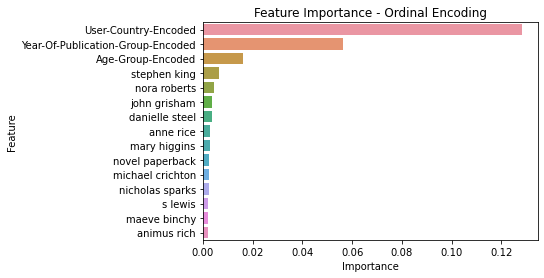

In [20]:
sns.barplot(feature_importance_df.head(15), x = 'Importance', y = 'Feature')
plt.title('Feature Importance - Ordinal Encoding')

In [21]:
y_pred = pipeline.predict(X_test)

## Results

In [22]:
y_pred_train = pipeline.predict(X_train)

accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report (Training Set):")
print(classification_report(y_train, y_pred_train))

# Display confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix (Training Set):")
print(conf_matrix_train)

Accuracy: 0.971309227458757
Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      6891
           1       0.97      0.97      0.97      8360
           2       1.00      0.95      0.97      8450

    accuracy                           0.97     23701
   macro avg       0.97      0.97      0.97     23701
weighted avg       0.97      0.97      0.97     23701

Confusion Matrix (Training Set):
[[6877    4   10]
 [ 247 8113    0]
 [ 203  216 8031]]


In [23]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix_train = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix_train)

Accuracy: 0.4292946338170773
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.41      0.36      0.39      1688
           1       0.41      0.49      0.45      2128
           2       0.47      0.42      0.45      2110

    accuracy                           0.43      5926
   macro avg       0.43      0.42      0.43      5926
weighted avg       0.43      0.43      0.43      5926

Confusion Matrix (Test Set):
[[ 611  696  381]
 [ 477 1046  605]
 [ 392  831  887]]


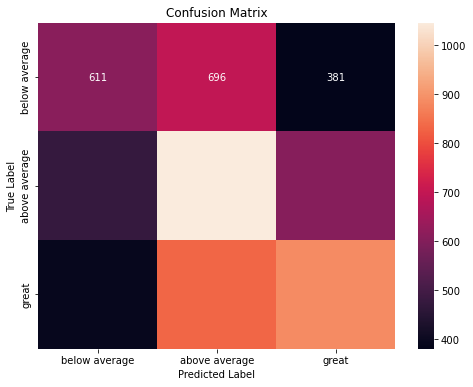

In [24]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
# issue with version of seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, fmt='d', annot = True,
            xticklabels=['below average', 'above average', 'great'],
            yticklabels=['below average', 'above average', 'great'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [25]:
cm

array([[ 611,  696,  381],
       [ 477, 1046,  605],
       [ 392,  831,  887]])

## Able to estimate popularity:

In [26]:
example_dict = {'Book-Info':'harry potter by j k rowling',
                          'User-Country-Encoded':65, 'Age-Group-Encoded':1,
                'Year-Of-Publication-Group-Encoded':7}

X_example = pd.DataFrame(example_dict, index = [0])
X_example

,Book-Info,User-Country-Encoded,Age-Group-Encoded,Year-Of-Publication-Group-Encoded
0,harry potter by j k rowling,65,1,7


In [27]:
# bins for weighted rating: 4.20336529, 7.57571908, 8.05047939, 9.51708247]
# between 8.050 and 9.517
# great
pipeline.predict(X_example)[0]

2

## Train Model/Split into train and test set
### One Hot Encoding
also want to do cross validation to get mean of models

In [28]:
X = df[['Book-Info', 'User-Country', 'Age-Group', 'Year-Of-Publication-Group']]
y = df['weighted_ratings_group_encoded']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [30]:
X_train.head(1)

,Book-Info,User-Country,Age-Group,Year-Of-Publication-Group
7870,face the fire three sister island trilogy by n...,netherlands,"(34.0, 46.0]","(1999, 2009]"


In [34]:
# Define text preprocessing (TF-IDF vectorization) and numeric preprocessing pipelines
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer = "word", ngram_range=(2,2), tokenizer=word_tokenize, stop_words='english'))
])

# Define column transformer to apply different preprocessing to specific columns
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'Book-Info'),
    ('group', OneHotEncoder(handle_unknown='ignore'), ['Age-Group', 'Year-Of-Publication-Group']),
    ('country', OneHotEncoder(handle_unknown='ignore'), ['User-Country'])
])

# Define the full pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [35]:
%%time
scores = cross_val_score(pipeline, X_train, y_train, cv=5)

CPU times: user 13.5 s, sys: 671 ms, total: 14.2 s
Wall time: 15.6 s


In [36]:
print("Cross-validation scores:", scores)

Cross-validation scores: [0.42733601 0.43164557 0.42320675 0.42172996 0.42932489]


In [37]:
%%time
# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

CPU times: user 3.39 s, sys: 252 ms, total: 3.64 s
Wall time: 4.17 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(ngram_range=(2,
                                                                                                2),
                                                                                   stop_words='english',
                                                                                   tokenizer=<function word_tokenize at 0x17e69b100>))]),
                                                  'Book-Info'),
                                                 ('group',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Age-Group',
                                                   'Year-Of-Publication-Group']),
                                                 ('country',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['User-Country'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [38]:
feature_names = np.concatenate((pipeline.named_steps['preprocessor'].transformers_[0][1]['tfidf'] \
    .get_feature_names_out(),pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(),pipeline.named_steps['preprocessor'].transformers_[2][1].get_feature_names_out()))
len(feature_names)

9024

In [39]:
importance_scores = pipeline['classifier'].feature_importances_

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [40]:
feature_importance_df[feature_importance_df['Feature'].str.contains('potter')]

,Feature,Importance
3462,harry potter,0.001676
6239,potter s,0.000365
6237,potter paperback,0.000133
6240,potter sorcerer,0.000110
6235,potter goblet,0.000040
6234,potter chamber,0.000000
6236,potter order,0.000000
6238,potter prisoner,0.000000
6241,potter und,0.000000
6242,potter y,0.000000


In [41]:
feature_importance_df[feature_importance_df['Feature'].str.contains('j k')]

,Feature,Importance
3946,j k,0.00156


In [42]:
feature_importance_df[feature_importance_df['Feature'].str.contains('stephen')]

,Feature,Importance
7577,stephen king,0.006033
5416,neal stephenson,0.001000
7878,talisman stephen,0.000779
8111,tommyknockers stephen,0.000649
2347,dreamcatcher stephen,0.000627
...,...,...
4852,madder stephen,0.000000
5150,mile stephen,0.000000
4841,macabre stephen,0.000000
3048,fund stephen,0.000000


Text(0.5, 1.0, 'Feature Importance - One Hot Encoding')

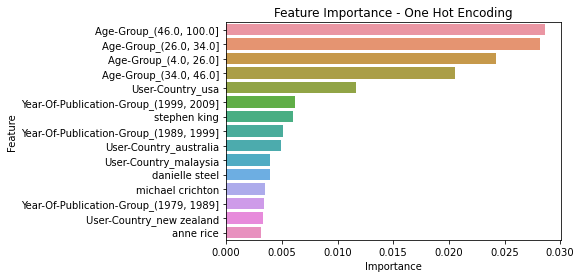

In [45]:
sns.barplot(feature_importance_df.head(15), x = 'Importance', y = 'Feature')
plt.title('Feature Importance - One Hot Encoding')

In [263]:
y_pred = pipeline.predict(X_test)

## Results

In [264]:
y_pred_train = pipeline.predict(X_train)

accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report (Training Set):")
print(classification_report(y_train, y_pred_train))

# Display confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix (Training Set):")
print(conf_matrix_train)

Accuracy: 0.971309227458757
Classification Report (Training Set):
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      6891
           1       0.97      0.97      0.97      8360
           2       1.00      0.95      0.97      8450

    accuracy                           0.97     23701
   macro avg       0.97      0.97      0.97     23701
weighted avg       0.97      0.97      0.97     23701

Confusion Matrix (Training Set):
[[6877    4   10]
 [ 247 8113    0]
 [ 203  216 8031]]


In [265]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix_train = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix_train)

Accuracy: 0.4319946000674992
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.41      0.39      0.40      1688
           1       0.41      0.44      0.43      2128
           2       0.46      0.46      0.46      2110

    accuracy                           0.43      5926
   macro avg       0.43      0.43      0.43      5926
weighted avg       0.43      0.43      0.43      5926

Confusion Matrix (Test Set):
[[660 604 424]
 [505 930 693]
 [431 709 970]]


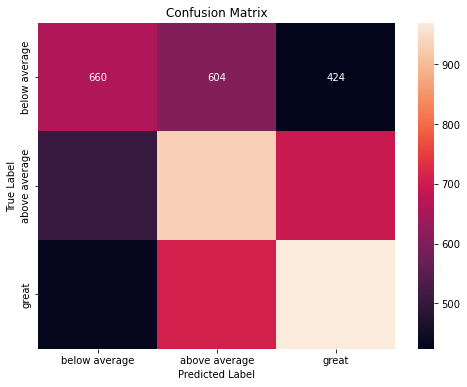

In [266]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
# issue with version of seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, fmt='d', annot = True,
            xticklabels=['below average', 'above average', 'great'],
            yticklabels=['below average', 'above average', 'great'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [267]:
cm

array([[660, 604, 424],
       [505, 930, 693],
       [431, 709, 970]])

## Able to estimate popularity:

In [271]:
example_dict = {'Book-Info':'harry potter by j k rowling',
                          'User-Country':'usa', 'Age-Group':'(4.0, 26.0]',
                'Year-Of-Publication-Group':'(1989,1999]'}

X_example = pd.DataFrame(example_dict, index = [0])
X_example

,Book-Info,User-Country,Age-Group,Year-Of-Publication-Group
0,harry potter by j k rowling,usa,"(4.0, 26.0]","(1989,1999]"


In [272]:
# bins for weighted rating: 4.20336529, 7.57571908, 8.05047939, 9.51708247]
# between 8.050 and 9.517
# great
pipeline.predict(X_example)[0]

2

## Pull in required data:

In [129]:
df = pd.read_csv(path + 'processed/processed_books_info.csv')

In [130]:
df.shape

(109393, 23)

In [131]:
df.head(1)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Book-Publisher,Book-Author-Processed,Book-Publisher-Processed,Book-Title-Processed,Book-Info,Book-Vector,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded,User-Country,User-Info,User-Info-Encoded,User-Country-Encoded,Age-Group-Encoded,Age-Group,average_rating,times_read,average_age,weighted_ratings,weighted_ratings_group_encoded
0,0399135782,The Kitchen God's Wife,Amy Tan,1991.0,Putnam Pub Group,amy tan,putnam pub group,the kitchen god s wife,the kitchen god s wife by amy tan,[0. 0. 0. ... 0. 0. 0.],"(1989, 1999]",7,malaysia,kuala lumpur_selangor_malaysia,5841,65,0,"(4.0, 26.0]",10.0,1,21.0,8.887138,2


# With User-Info
More detailed model around user location.
## Prepare model:

## Split into train and test set
also want to do cross validation to get mean of models

In [133]:
df.columns

Index(['ISBN', 'Book-Title', 'Book-Author', 'Year-Of-Publication',
       'Book-Publisher', 'Book-Author-Processed', 'Book-Publisher-Processed',
       'Book-Title-Processed', 'Book-Info', 'Book-Vector',
       'Year-Of-Publication-Group', 'Year-Of-Publication-Group-Encoded',
       'User-Country', 'User-Info', 'User-Info-Encoded',
       'User-Country-Encoded', 'Age-Group-Encoded', 'Age-Group',
       'average_rating', 'times_read', 'average_age', 'weighted_ratings',
       'weighted_ratings_group_encoded'],
      dtype='object')

In [167]:
X = df[['Book-Info', 'User-Country-Encoded', 'User-Info-Encoded', 'Age-Group-Encoded', 'Year-Of-Publication-Group-Encoded']]
y = df['weighted_ratings_group_encoded']

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [169]:
X_train.head(1)

,Book-Info,User-Country-Encoded,User-Info-Encoded,Age-Group-Encoded,Year-Of-Publication-Group-Encoded
2411,the catcher in the rye by j d salinger,124,9393,1,7


## Train Model

In [170]:
# Define text preprocessing (TF-IDF vectorization) and numeric preprocessing pipelines
text_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer = "word", ngram_range=(2,2), tokenizer=word_tokenize, stop_words='english'))
])

# Define column transformer to apply different preprocessing to specific columns
preprocessor = ColumnTransformer([
    ('text', text_pipeline, 'Book-Info'),
    ('group', 'passthrough', ['Age-Group-Encoded', 'Year-Of-Publication-Group-Encoded']),
    ('country', 'passthrough', ['User-Country-Encoded', 'User-Info-Encoded'])
])

# Define the full pipeline with preprocessing and model
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

In [171]:
%%time
scores = cross_val_score(pipeline, X_train, y_train, cv=5)

CPU times: user 40.6 s, sys: 1.1 s, total: 41.7 s
Wall time: 44 s


In [172]:
print("Cross-validation scores:", scores)

Cross-validation scores: [0.44146718 0.44860881 0.44295264 0.44215277 0.44629185]


In [173]:
%%time
# Fit the pipeline on training data
pipeline.fit(X_train, y_train)

CPU times: user 9.62 s, sys: 156 ms, total: 9.77 s
Wall time: 10 s


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('text',
                                                  Pipeline(steps=[('tfidf',
                                                                   TfidfVectorizer(ngram_range=(2,
                                                                                                2),
                                                                                   stop_words='english',
                                                                                   tokenizer=<function word_tokenize at 0x16e39b100>))]),
                                                  'Book-Info'),
                                                 ('group', 'passthrough',
                                                  ['Age-Group-Encoded',
                                                   'Year-Of-Publication-Group-Encoded']),
                                                 ('country', 'passthrough',
                                                  ['User-Country-Encoded',
                                                   'User-Info-Encoded'])])),
                ('classifier', DecisionTreeClassifier(random_state=42))])

In [174]:
feature_names = np.concatenate((pipeline.named_steps['preprocessor'].transformers_[0][1]['tfidf'] \
    .get_feature_names_out(),['User-Country-Encoded', 'User-Info-Encoded', 'Age-Group-Encoded', 'Year-Of-Publication-Group-Encoded']))
len(feature_names)

8913

In [175]:
importance_scores = pipeline['classifier'].feature_importances_

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

In [176]:
feature_importance_df[feature_importance_df['Feature'].str.contains('potter')]

,Feature,Importance
3462,harry potter,0.003757
6237,potter paperback,0.000147
6239,potter s,0.000114
6235,potter goblet,0.000067
6240,potter sorcerer,0.000061
6234,potter chamber,0.000048
6238,potter prisoner,0.000035
6236,potter order,0.000028
6241,potter und,0.000000
6242,potter y,0.000000


In [177]:
feature_importance_df[feature_importance_df['Feature'].str.contains('j k')]

,Feature,Importance
3946,j k,0.000115


In [178]:
feature_importance_df[feature_importance_df['Feature'].str.contains('stephen')]

,Feature,Importance
7577,stephen king,0.004127
5416,neal stephenson,0.000377
7878,talisman stephen,0.000297
2140,desperation stephen,0.000280
7581,stephen white,0.000249
...,...,...
3048,fund stephen,0.000000
4751,lot stephen,0.000000
4841,macabre stephen,0.000000
145,5 stephen,0.000000


<Axes: xlabel='Importance', ylabel='Feature'>

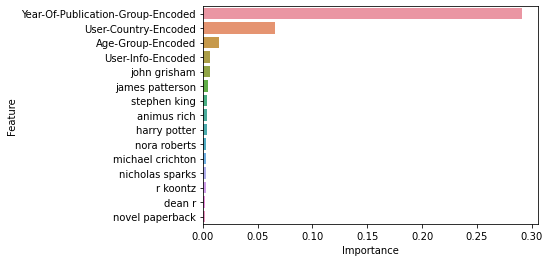

In [179]:
sns.barplot(feature_importance_df.head(15), x = 'Importance', y = 'Feature')

In [180]:
y_pred = pipeline.predict(X_test)

## Results

In [181]:
y_pred_train = pipeline.predict(X_train)

accuracy = accuracy_score(y_train, y_pred_train)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report (Training Set):")
print(classification_report(y_train, y_pred_train))

# Display confusion matrix
conf_matrix_train = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix (Training Set):")
print(conf_matrix_train)

Accuracy: 0.9984459629316452
Classification Report (Training Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     18176
           1       1.00      1.00      1.00     37151
           2       1.00      1.00      1.00     32187

    accuracy                           1.00     87514
   macro avg       1.00      1.00      1.00     87514
weighted avg       1.00      1.00      1.00     87514

Confusion Matrix (Training Set):
[[18176     0     0]
 [   44 37107     0]
 [   33    59 32095]]


In [182]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Display classification report
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

# Display confusion matrix
conf_matrix_train = confusion_matrix(y_test, y_pred)
print("Confusion Matrix (Test Set):")
print(conf_matrix_train)

Accuracy: 0.44764385940856527
Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.31      0.22      0.26      4608
           1       0.47      0.57      0.51      9173
           2       0.48      0.44      0.46      8098

    accuracy                           0.45     21879
   macro avg       0.42      0.41      0.41     21879
weighted avg       0.44      0.45      0.44     21879

Confusion Matrix (Test Set):
[[1025 2364 1219]
 [1282 5193 2698]
 [ 955 3567 3576]]


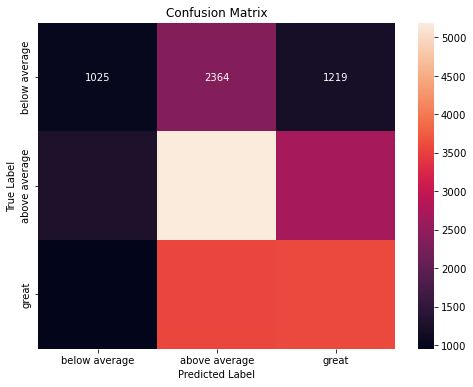

In [183]:
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
# issue with version of seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, fmt='d', annot = True,
            xticklabels=['below average', 'above average', 'great'],
            yticklabels=['below average', 'above average', 'great'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [184]:
cm

array([[1025, 2364, 1219],
       [1282, 5193, 2698],
       [ 955, 3567, 3576]])

## Able to estimate popularity:

In [ ]:
example_dict = {'Book-Info':'harry potter by j k rowling',
                          'User-Country-Encoded':65, 'Age-Group-Encoded':0,
                'Year-Of-Publication-Group-Encoded':7}

X_example = pd.DataFrame(example_dict, index = [0])
X_example

In [ ]:
# bins for weighted rating: 4.20336529, 7.57571908, 8.05047939, 9.51708247]
# between 8.050 and 9.517
# great
pipeline.predict(X_example)[0]

## Dataset info:

In [154]:
df[['Year-Of-Publication-Group', 'Year-Of-Publication-Group-Encoded']].drop_duplicates()

,Year-Of-Publication-Group,Year-Of-Publication-Group-Encoded
0,"(1989, 1999]",7
251,"(1999, 2009]",8
1054,"(1979, 1989]",6
7947,"(1959, 1969]",4
7995,"(1969, 1979]",5
28001,"(1949, 1959]",3
82526,"(1929, 1939]",1


In [64]:
df[['Age-Group', 'Age-Group-Encoded']].drop_duplicates()

,Age-Group,Age-Group-Encoded
0,"(4.0, 26.0]",0
1,"(26.0, 34.0]",1
2,"(46.0, 100.0]",3
5,"(34.0, 46.0]",2


In [65]:
df[['User-Country', 'User-Country-Encoded']].drop_duplicates()

,User-Country,User-Country-Encoded
0,malaysia,65
1,unknown,121
3,usa,124
7,australia,7
8,brazil,15
...,...,...
27737,urugua,122
31652,croatia,25
33861,u.s.a.,115
34124,tajikistan,107


In [66]:
df['weighted_ratings_group_encoded'].drop_duplicates()

0    2
1    1
4    0
Name: weighted_ratings_group_encoded, dtype: int64